In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


## Train Data

In [2]:
#For building this model, I will be using the face mask dataset provided by Prajna Bhandary. 
#It consists of about 1,376 images with 690 images containing people with face masks 
#and 686 images containing people without face masks.

project_path = '/content/MyDrive/MyDrive/Colab Notebooks/data/'
training_zip_path = project_path + 'face-mask-detector.zip'
from zipfile import ZipFile

with ZipFile(training_zip_path, 'r') as z:
  z.extractall()
print("Training zip extraction done!")

Training zip extraction done!


In [3]:
%cd /content/face-mask-detector

/content/face-mask-detector


In [5]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

[Loading images...]
9412608/9406464 [==============================] - 0s 0us/step
Compiling our model...
Training head...
Epoch 1/20
34/34 [==============================] - 55s 2s/step - loss: 0.4736 - accuracy: 0.7856 - val_loss: 0.1231 - val_accuracy: 0.9674
Epoch 2/20
34/34 [==============================] - 54s 2s/step - loss: 0.1261 - accuracy: 0.9588 - val_loss: 0.0671 - val_accuracy: 0.9819
Epoch 3/20
34/34 [==============================] - 54s 2s/step - loss: 0.0687 - accuracy: 0.9813 - val_loss: 0.0514 - val_accuracy: 0.9855
Epoch 4/20
34/34 [==============================] - 54s 2s/step - loss: 0.0519 - accuracy: 0.9860 - val_loss: 0.0447 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 54s 2s/step - loss: 0.0408 - accuracy: 0.9916 - val_loss: 0.0405 - val_accuracy: 0.9855
Epoch 6/20
34/34 [==============================] - 54s 2s/step - loss: 0.0371 - accuracy: 0.9869 - val_loss: 0.0361 - val_accuracy: 0.9891
Epoch 7/20
34/34 [===================

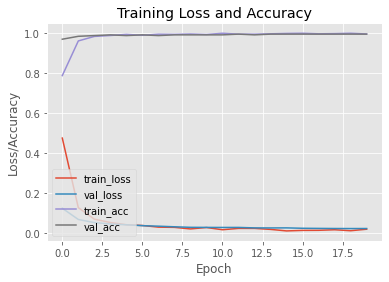

In [6]:
# initialize the learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# We will grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[Loading images...]")
imagePaths = list(paths.list_images('/content/face-mask-detector/dataset'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:

	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224-> Because we're using MobileNET and its need 224 by 224 images). then we will preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels list respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Split the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
# We augmented our dataset to include more number of images for our training. 
# We rotate and flip, zoom each of the images in our dataset

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# We have choosen to use MobileNet because it's way smaller in size and faster in performance than many other popular models.
# load the MobileNetV2 network, ensuring the head FC layer sets areleft off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model, this will become the actual model we will train.
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they can't be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("Compiling our model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


# train the head of the network
print("Training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("Evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# We will plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Detect Mask from Image

In [8]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow

Computing face detections...


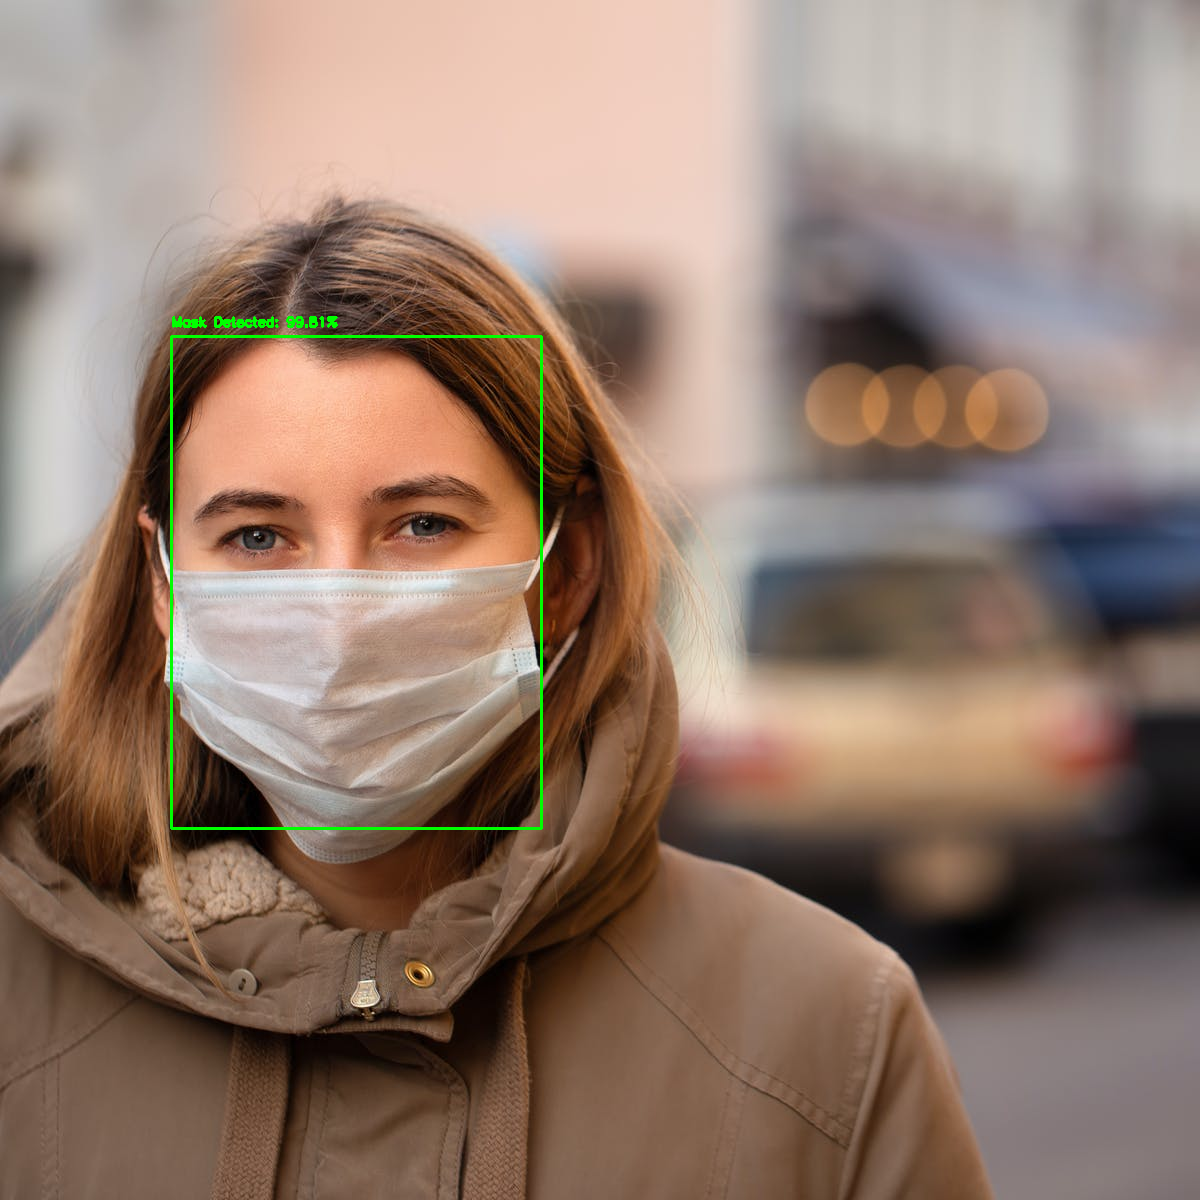

-1

In [11]:
# load the test image and clone it, and grab the image spatial dimensions
#commented line: personne without mask
#image = cv2.imread('/content/face-mask-detector/leo_dicaprio.jpg')

#personne with mask
image = cv2.imread('/content/face-mask-detector/person_withMask.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

net=cv2.dnn.readNet('/content/face-mask-detector/face_detector/deploy.prototxt','/content/face-mask-detector/face_detector/res10_300x300_ssd_iter_140000.caffemodel')

# pass the blob through the network and obtain the face detections
print("Computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (probability) associated with the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face has a mask or not
		(mask, withoutMask) = model.predict(face)[0]
    # determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask Detected" if mask > withoutMask else "No Mask Detected"
		color = (0, 255, 0) if label == "Mask Detected" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and the red box rectangle on the output frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
cv2_imshow(image)
cv2.waitKey(0)

## Mask Detection from Video

In [12]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

In [13]:
#Pretty much the same code as the previous one, with some minor changes

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations, and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (probability) associated with the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))
# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on all faces at the same time rather than one-by-one predictions
		# in the above for loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding locations
	return (locs, preds)

faceNet=cv2.dnn.readNet('/content/face-mask-detector/face_detector/deploy.prototxt','/content/face-mask-detector/face_detector/res10_300x300_ssd_iter_140000.caffemodel')

To test the system on Google Colab

In [14]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
       }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [15]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

In [ ]:
import imutils
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)

	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
  frame = image
  v=True
  if v == True:

    frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):

# unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
      cv2_imshow(frame)